# <center> House Prices </center>

## <center> 1. Introduction </center>

### <center>1.1 Problem Description</center>
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, dataset challenges to predict the final price of each home.

### <center> 1.2 Goal </center>
A goal is to predict the sales price for each house. For each Id in the test set, predict the value of the SalePrice variable.


### <center> 1.3 Metric </center>

Predicted values are evaluated on Root-Mean-Squared-Error (RMSE). Deviation in predicting expensive and cheap houses will affect the result equally. Root-Mean-Squared-Error metric will define how well a certain model is performing. The final model must have deviation within 10%

### <center> 1.4 Tools </center>
The following libraries were used to build the model:
* numpy - A python library for working with arrays.
* pandas - High-level data representation and manipulation tool.
* matplotlib - A library for creating visualizations.
* seaborn - A library for making statistical graphics in Python.
* scipy -  A python library for scientific and mathematical purposes.
* statsmodels - A library for the estimation of many different statistical models.
* sklearn - A library to solve machine learning problems.

## <center> 2. Implementation </center>

### <center> 2.1 Dataset overview </center>


In order to implement and run the model, appropriate libraries must be imported first.


In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import time

In [420]:
import sklearn
from sklearn.preprocessing import StandardScaler,OneHotEncoder,RobustScaler
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [317]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,SGDRegressor,LogisticRegression,LassoCV,lasso_path
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import feature_selection

Next step is loading the initial data to variables.

In [318]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

First several rows can give a good sense of what kind of data we are dealing with, which properties exist and what are their types.

In [319]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


As we can see, dataset contains a lot of NaN's.  
Let's find out and display features with the most amount of missing data.

In [320]:
(train.isnull().sum()/len(train)*100).sort_values(ascending=False)[:20]

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageCond       5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
Utilities        0.000000
dtype: float64

Plot target value graph and its distribution.

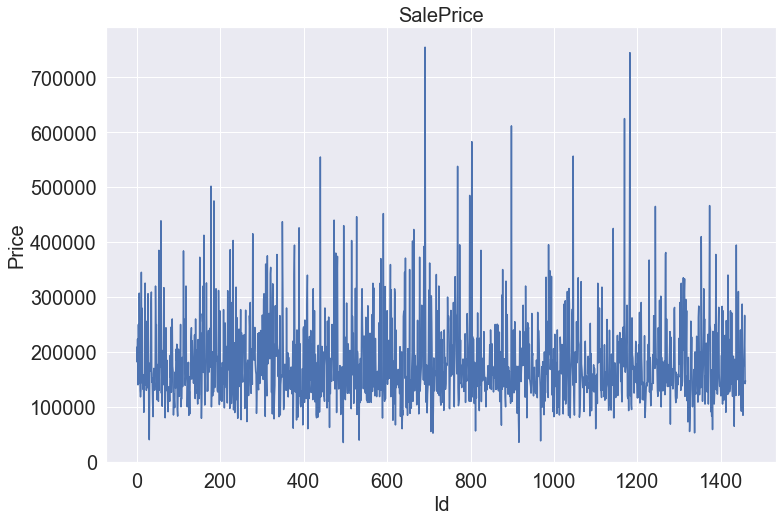

In [321]:
train.SalePrice.plot(figsize=(12,8))
plt.title('SalePrice',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.xlabel('Id',fontsize=20);

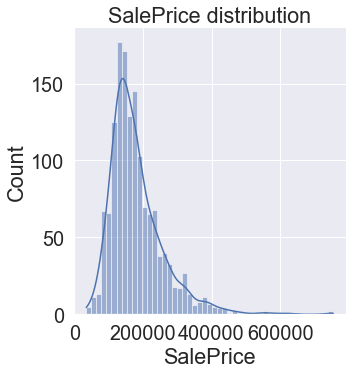

In [322]:
sns.displot(train.SalePrice,kde=True)
plt.title('SalePrice distribution');

Probability plot shows deviation from the normal distribution line. But Shapiro-Wilk test proves that SalePrice is normally distributed.

Shapiro-Wilk test : 3.206247534576162e-33


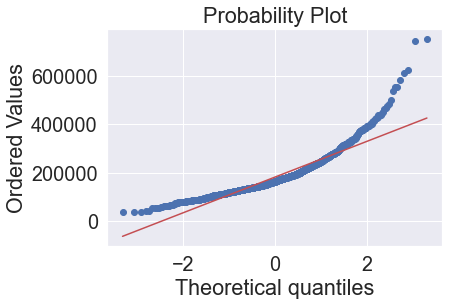

In [323]:
stats.probplot(train.SalePrice,plot=plt)[1]
print('Shapiro-Wilk test :',
      stats.shapiro(train.SalePrice)[1])

### <center> 2.2 Data cleaning </center>

To process data we need to separate columns to numeric and categoric.

In [324]:
numeric = np.where((train.dtypes=='int')|(train.dtypes=='float'))[0]
categoric = np.where(train.dtypes=='object')[0]
print('Numerical features : ',train.columns[numeric].values,'\nAmount: ',len(numeric))
print('Categorical features : ',train.columns[categoric].values,'\nAmount:',len(categoric))
print('Numeric-categoric ratio = {} that is close to 1 '.format(round(len(numeric)/len(categoric),2)))

Numerical features :  ['Id' 'MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF'
 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold'
 'SalePrice'] 
Amount:  38
Categorical features :  ['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'Gara

Most of the machine learning models can't handle with missing data, so cleaning dataset from nan's would be a great idea.  
This function drops columns with 40 or more percentage of missing values.  
And fills 'NaN' with median in numeric and most frequent in categoric column.

In [325]:
def cleaning_na(data):
    columns_with_na = np.where(data.isna().sum()>0)[0]
    columns_to_drop = (data.iloc[:,columns_with_na].isna().sum()/data.shape[0]*100)>40
    columns_number = columns_with_na[np.where((data.iloc[:,columns_with_na].dtypes=='float')|(data.iloc[:,columns_with_na].dtypes=='int'))[0]]
    columns_cat =  columns_with_na[np.where(data.iloc[:,columns_with_na].dtypes=='object')[0]]
    data.iloc[:,columns_number] = data.iloc[:,columns_number].apply(lambda x:x.fillna(x.median()))
    for column in columns_cat:
        data.iloc[:,column].fillna(data.iloc[:,column].mode()[0],inplace=True)
    data.drop(data.columns[columns_with_na[columns_to_drop]],axis=1,inplace=True)
    data.drop('Id',axis=1,inplace=True)
cleaning_na(train)
cleaning_na(test)

Pearson and Spearman linear correlation test shows relation between each column and target value (SalePrice).  
Results those are less than 0.05 can be omitted in further calculation due to their statistical insignificanty.

In [326]:
numeric = np.where((train.dtypes=='int')|(train.dtypes=='float'))[0]
pear = {}
spear = {}
for col in numeric:
    col_name = train.columns[col]
    pear[col_name] = stats.pearsonr(train[col_name],train['SalePrice'])[0]
    spear[col_name] = stats.spearmanr(train[col_name],train['SalePrice'])[0]

In [327]:
print('Statistically insignificant(pearson corr)')
feat_to_drop_pear = {}
for feature in pear.items():
    if abs(feature[1])<0.05:
        feat_to_drop_pear[feature[0]]=feature[1]
print(pd.Series(feat_to_drop_pear))

Statistically insignificant(pearson corr)
BsmtFinSF2     -0.011378
LowQualFinSF   -0.025606
BsmtHalfBath   -0.016844
3SsnPorch       0.044584
MiscVal        -0.021190
MoSold          0.046432
YrSold         -0.028923
dtype: float64


In [328]:
print('Statistically insignificant(spearman corr)')
feat_to_drop_spear = {}
for feature in spear.items():
    if abs(feature[1])<0.05:
        feat_to_drop_spear[feature[0]]=feature[1]
print(pd.Series(feat_to_drop_spear))

Statistically insignificant(spearman corr)
MSSubClass      0.007192
BsmtFinSF2     -0.038806
BsmtHalfBath   -0.012189
YrSold         -0.029899
dtype: float64


Found columns indeed don't have enough correlation with SalePrice. The charts below demonstrate it.

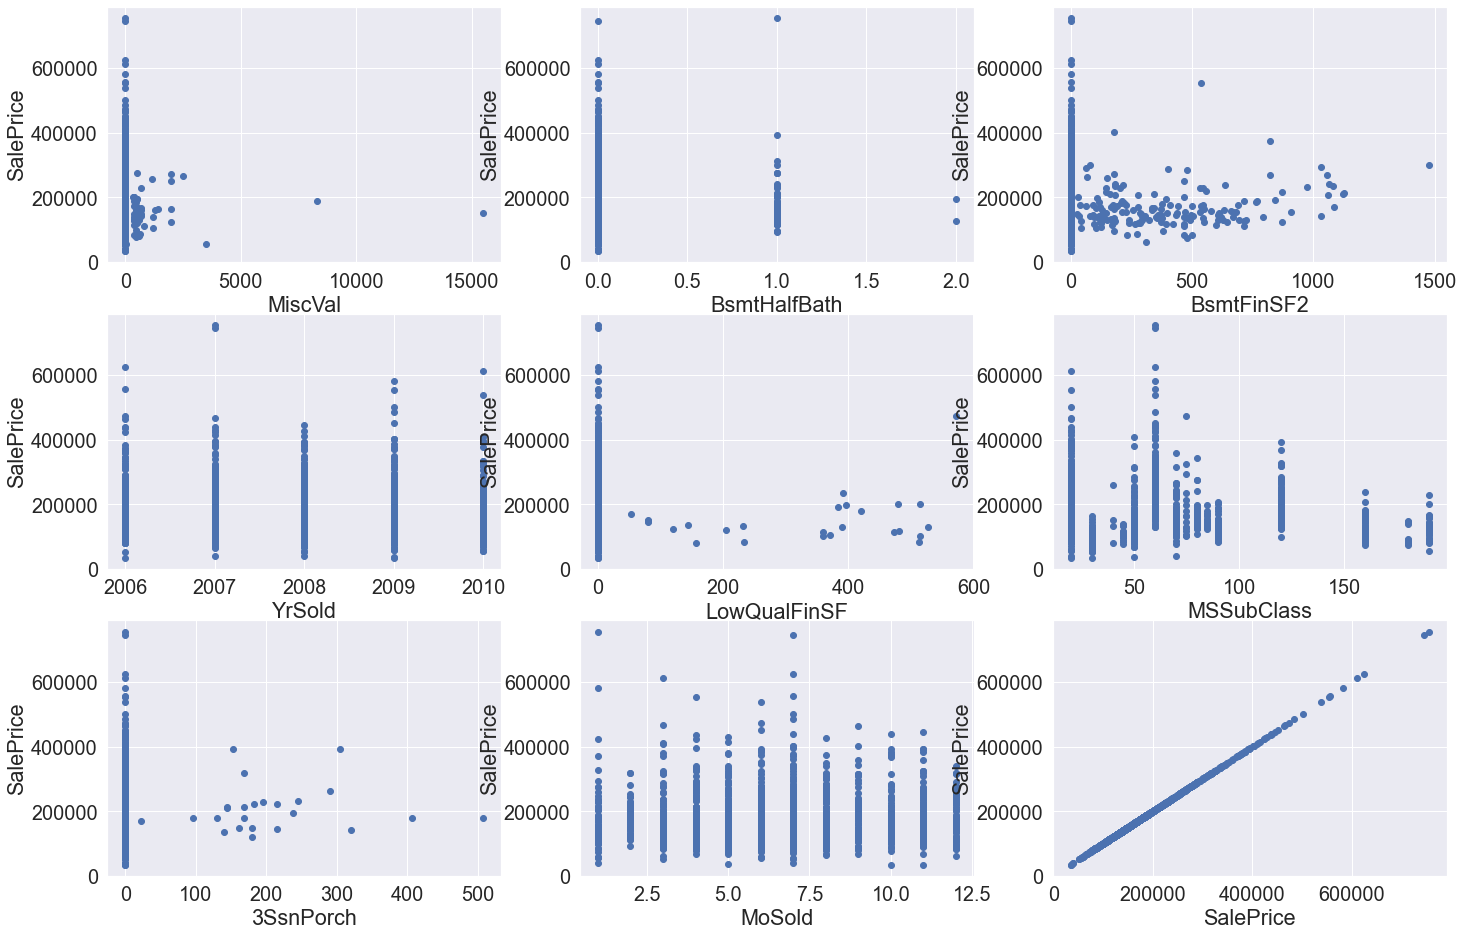

In [329]:
feat_to_draw = list(set(feat_to_drop_pear.keys()).union(set(feat_to_drop_spear.keys()))) 
feat_to_draw.append('SalePrice')
plt.figure(figsize=(24,16))
for i in range(len(feat_to_draw)):
    plt.subplot(3,3,i+1)
    plt.scatter(train[feat_to_draw[i]],train.SalePrice)
    plt.xlabel(str(feat_to_draw[i]))
    plt.ylabel('SalePrice')

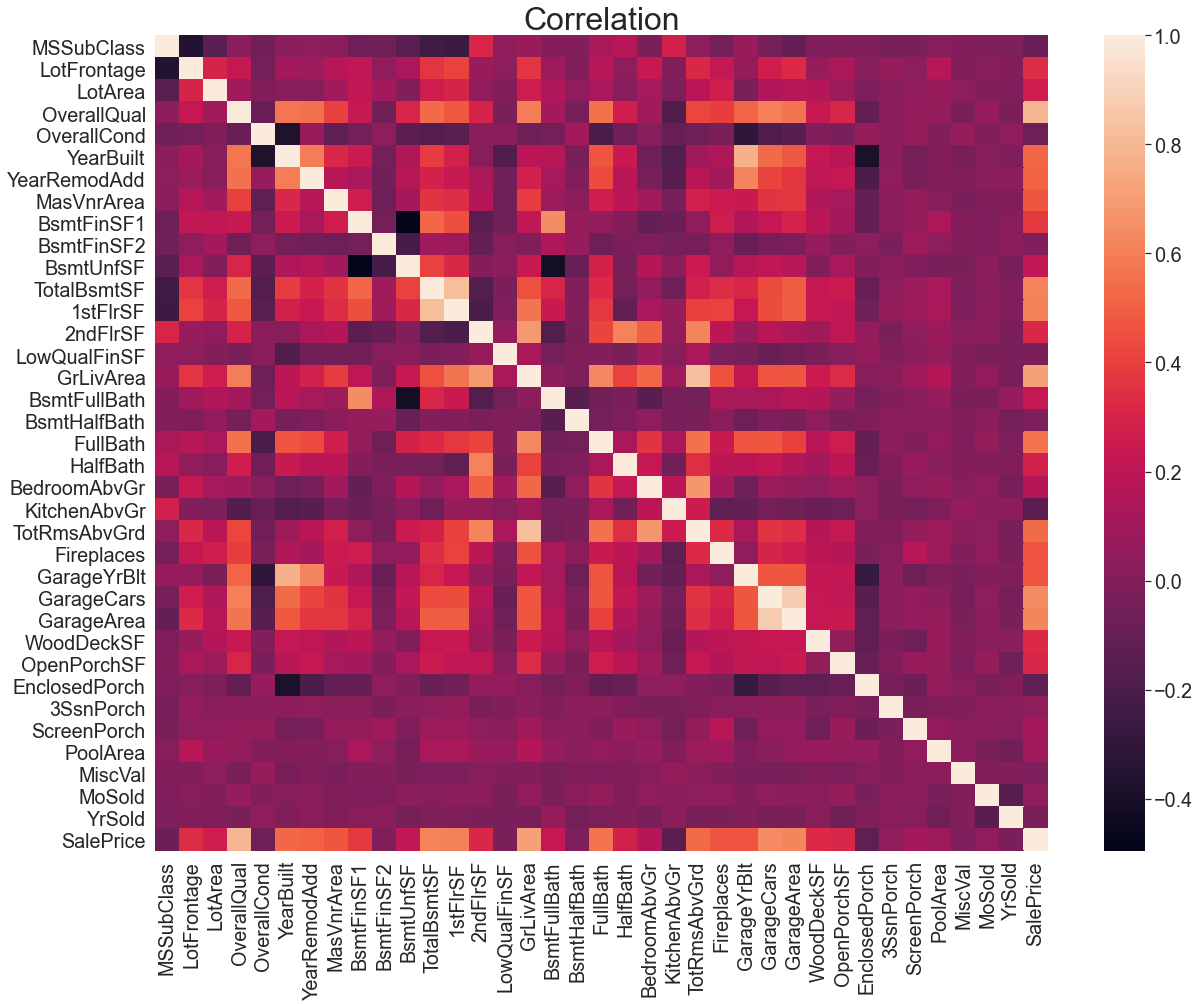

In [330]:
#Correlation map to see how features are correlated with SalePrice
corr = train.corr()
plt.figure(figsize=(20,15))
sns.set(font_scale=1.8)
sns.heatmap(corr)
plt.title('Correlation',fontsize=32);

It's time to build basic regression model from statsmodels module with statistical useful information (Kurtosis, Skew etc...)

In [331]:
train.rename(columns={'1stFlrSF':'FirstFlrSF','2ndFlrSF':'SecondFlrSF','3SsnPorch':'ThirdSsnPorch'},inplace=True)
test.rename(columns={'1stFlrSF':'FirstFlrSF','2ndFlrSF':'SecondFlrSF','3SsnPorch':'ThirdSsnPorch'},inplace=True)
feats = list(train.columns[numeric].drop('SalePrice'))
features_string = " + ".join(feats)

In [332]:
regression_model = smf.ols('SalePrice ~ ' + features_string , data=train)
fitted = regression_model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     182.4
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:38:39   Log-Likelihood:                -17319.
No. Observations:                1460   AIC:                         3.471e+04
Df Residuals:                    1425   BIC:                         3.489e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.628e+05   1.41e+06      0.327

Model shows that some of the features create multicollinearity problems (they are not informative) and should be removed.

In [333]:
feats = np.array(feats)
feats_pvalue = fitted.pvalues>0.65
feats[feats_pvalue[1:]]

array(['BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GarageArea',
       'OpenPorchSF', 'MiscVal', 'MoSold'], dtype='<U13')

Merge and delete unnecessary columns to further combat multicollinearity and reduce noisiness.

In [334]:
feat_to_drop = list(set(feat_to_drop_pear).union(set(feat_to_drop_spear)).union(set(feats[feats_pvalue[1:]])))
feats = set(train.columns[numeric].drop('SalePrice')).intersection(set(feat_to_drop))
train.drop(feats, axis=1, inplace=True)
test.drop(feats, axis=1, inplace=True)

Achieved  R-squared: 0.813 with only numeric features which is pretty good result. Further preprocessing and feature engineering will increase linear model's accuracy.

### <center> 2.3 Preproccesing </center>
For achieving better results from the model in Machine Learning the format of the data has to be in a proper manner.  
Our data is comprised of attributes with varying scales, many machine learning algorithms can benefit from rescaling the attributes to all have the same scale. Standardization transforms data to have a mean of zero and a standard deviation of 1 of numeric features.  
Also we can include categoric values after one hot encoding. It is a representation of categorical variables as binary vectors (transform categoric to numeric).

In [335]:
#Separate target value (SalePrice)
X = train.drop('SalePrice',axis=1)
y = train.SalePrice
categorical_cols = np.where(X.dtypes=='object')[0]
numerical_cols = np.where((X.dtypes=='float')|(X.dtypes=='int'))[0]

In [336]:
#Define classes for preprocessing
scaler = StandardScaler()
cat = OneHotEncoder(handle_unknown='ignore')

In [337]:
#standartization 
X.iloc[:,numerical_cols] = scaler.fit_transform(X.iloc[:,numerical_cols])
test.iloc[:,numerical_cols] = scaler.transform(test.iloc[:,numerical_cols])
#onehotencoding
X_cat = cat.fit_transform(X.iloc[:,categorical_cols])
test_cat = cat.transform(test.iloc[:,categorical_cols])

In [338]:
#Merge to resulting 2d array
X_all = X.drop(X.columns[categorical_cols],axis=1,inplace=True)
test_all = test.drop(test.columns[categorical_cols],axis=1,inplace=True)
X_all = np.hstack((X,X_cat.toarray()))
test_all = np.hstack((test,test_cat.toarray()))

### <center> 2.4 t-SNE </center>
T-SNE is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions.  
DBScan is a density-based clustering non-parametric algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors).  
Many clusters stand apart, which means that something unites them.

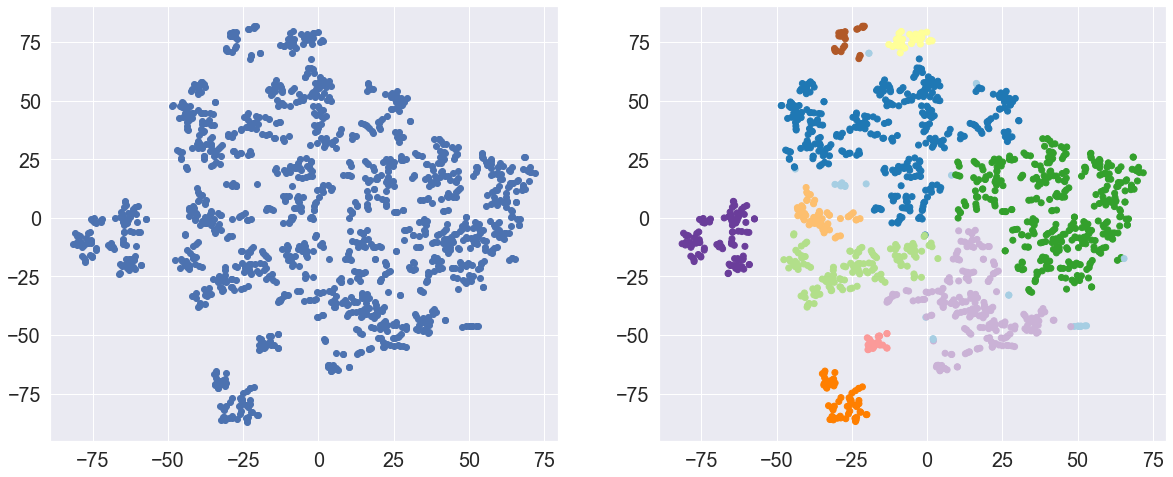

In [339]:
#2d interpretaion of all values
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
numeric = np.where((X.dtypes == 'int')|(X.dtypes == 'float'))[0]
tsne = TSNE(perplexity=10,random_state=5)
tsne_result = tsne.fit_transform(X.iloc[:,numeric])
plt.scatter(tsne_result[:,1],tsne_result[:,0])
#clustering
plt.subplot(1,2,2)
dbscan = DBSCAN(eps=7,min_samples=12).fit_predict(tsne_result)
plt.scatter(tsne_result[:,1],tsne_result[:,0],c=dbscan,cmap='Paired');

### <center> 2.5 Feature selection </center>
If dataset contains many columns it can be a problem because some of them add noisiness and increase training time. One of the solution is dropping not informative columns. The other way is to let model decide which columns are useless. Lasso (least absolute shrinkage and selection operator) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces.  
Let's train lasso model to check prediction errors.



In [340]:
numeric=np.where((X.dtypes=='int')|(X.dtypes=='float'))[0]
lasso = Lasso(alpha=10000,random_state=5)
fitted = lasso.fit(X.iloc[:,numeric],y)
pd.DataFrame({'coef':fitted.coef_},index = train.columns[numeric]).sort_values(by='coef',ascending=False)[:10]

,coef
LotArea,29560.054191
Condition2,19390.484841
Exterior1st,8104.089499
LandSlope,5421.805695
LotConfig,2921.160682
Neighborhood,2738.543841
LotShape,1882.449250
LandContour,1179.474192
Utilities,596.149900
MasVnrType,-0.000000


Increasing alpha increases l1 regularization thereby selects the most necessary features and makes zero not important.

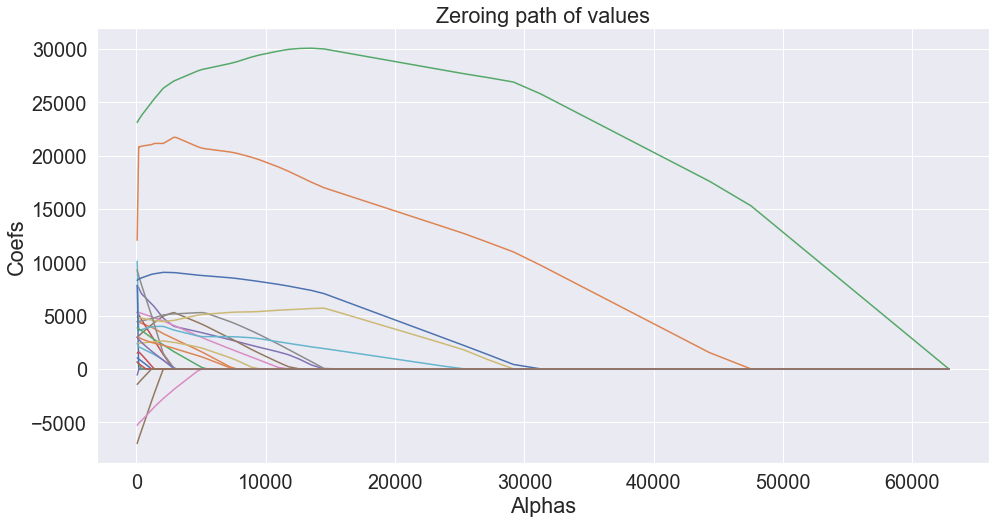

In [341]:
alphas,coefs,_ = lasso_path(X.iloc[:,numeric],y)
plt.figure(figsize=(16,8))
plt.plot(alphas,coefs.T)
plt.xlabel('Alphas')
plt.ylabel('Coefs')
plt.title('Zeroing path of values');

LassoCV automatically finds optimal alpha value

In [342]:
lasso = LassoCV(random_state=5)
cvs = cross_val_score(lasso,X_all,y,cv=5,scoring='neg_root_mean_squared_error')
print(f'Lasso RMSE score: {np.int(np.abs(cvs.mean()))}')

Lasso RMSE score: 30234


In [343]:
X_train,X_test,y_train,y_test = train_test_split(X_all,y,random_state=5)
lasso = LassoCV(random_state=5)
lasso.fit(X_train,y_train)
lasso_prediction = lasso.predict(X_test)

In [344]:
print('MAPE:',np.sum(np.abs((y_test-lasso_prediction)/y_test*100))/lasso_prediction.shape[0])

MAPE: 10.389504159002595


Unfortunately, lasso algorithm unable to reach percentage deviation condition. Other models may be able to achieve the necessary. 

## <center> 3. Model tuning </center>
Finding optimal hyperparameters for model can impove its perfomance significantly. So, let's compare different models to find most accurate.

### <center> 3.1 Comparison scores with base estimators </center>

Make dataframe for results.

In [360]:
results = pd.DataFrame(columns = ['name','cross_val_score','time'])

Function for cross validation different algorithms.

In [387]:
def evaluate_score(model,X,y):
    ''' 
    Function counts cross-validation score, time (overall train + prediction) of model.
    Crossval score is evaluated in RMSE metric, cv folds = 3.
    
    '''
    time_before = time.time() 
    model_instance = model
    cvs = np.int(np.abs(cross_val_score(model,X,y,cv=5,scoring='neg_root_mean_squared_error').mean()))
    if cvs>1e11:
        cvs = np.inf

    time_after = time.time()
    result = pd.DataFrame({'name':model.__class__.__name__,'cross_val_score':cvs,
                           'time':time_after - time_before},index=[0])
    return result

Next, compare linear, tree and distance different algorithms.

In [357]:
#tree models : DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor
#distance models : KNeighborsRegressor
#linear models : LinearRegression, Ridge, Lasso, SGDRegressor
regressors = [Ridge(random_state = 5),
              Lasso(random_state=5),DecisionTreeRegressor(random_state=5),
              SGDRegressor(random_state=5),GradientBoostingRegressor(random_state=5),
              RandomForestRegressor(random_state=5),KNeighborsRegressor()]

In [361]:
for regressor in regressors:
    results = results.append(evaluate_score(regressor))

/Users/borisevich.vd/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10685775899.579712, tolerance: 699031751.5199751
  model = cd_fast.enet_coordinate_descent(


Display scores in ascending order.

In [362]:
results.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,GradientBoostingRegressor,25506,3.076963
0,RandomForestRegressor,28955,8.583790
0,Ridge,31416,0.043942
0,SGDRegressor,31634,0.106600
0,Lasso,32985,0.726156
0,KNeighborsRegressor,37258,0.727971
0,DecisionTreeRegressor,39228,0.180871


### <center> 3.2 Comparison scores with tuned estimators  </center>

Firstly we have to find optimal paramters. Grid search is the most common decision.

In [363]:
results_grid = pd.DataFrame(columns = ['name','cross_val_score','time'])

In [379]:
def evaluate_score_grid(model,params,X,y):
    ''' Gridsearch for different models'''
    name = model.__class__.__name__
    time_before = time.time() 
    model_instance = GridSearchCV(model,params,cv=5,scoring='neg_root_mean_squared_error').fit(X,y)
    cvs = np.int(np.abs(model_instance.best_score_))
    print(model,model_instance.best_params_)
    if cvs>1e10:
        cvs=np.inf
    time_after = time.time()
    result = pd.DataFrame({'name':name,'cross_val_score':cvs,
                           'time':time_after - time_before},index=[0])
    return result

In [365]:
regressors = [Ridge(),Lasso(),DecisionTreeRegressor(),
              SGDRegressor(),GradientBoostingRegressor(),
              RandomForestRegressor(),KNeighborsRegressor()]

A parameter space for each model.

In [366]:
ridge_params = {
    'alpha':[1,1.5,2,5,10,100,200,500,1000],
    'max_iter':[1000,2000],
    'random_state':[5]
}
lasso_params = {
    'alpha':[1,1.5,2,5,10,100,200,500,1000],
    'max_iter':[1000,2000],
    'random_state':[5]
}
tree_params = {
    'max_depth':[3,5,8,10,15],
    'min_samples_leaf':[1,2,5,10],
    'random_state':[5]   
}
SGDRegressor_params = {
    'penalty':['l2','l1','elasticnet'],
    'max_iter':[1000,2000,5000],
    'learning_rate':['invscaling','optimal'],
    'random_state':[5]
}
GradientBoostingRegressor_params = {
    'learning_rate':[0.01,0.05,0.1],
    'n_estimators':[500,1000,2000],
    'random_state':[5]
}
RandomForestRegressor_params = {
    'n_estimators':[500,1000,2000],
    'max_depth':[5,10,None],
    'random_state':[5]
}
KNeighborsRegressor_params = {
    'n_neighbors':[3,5,7,9],
    'weights':['uniform','distance'],
    'algorithm':['ball_tree','kd_tree','brute']
}
params = [ridge_params,lasso_params,tree_params,
          SGDRegressor_params,GradientBoostingRegressor_params,
          RandomForestRegressor_params,KNeighborsRegressor_params]

In [368]:
%%time
for i,regressor in enumerate(regressors):
    results_grid = results_grid.append(evaluate_score_grid(regressor,params=params[i]))

Ridge() {'alpha': 10, 'max_iter': 1000, 'random_state': 5}


/Users/borisevich.vd/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10685775899.579712, tolerance: 699031751.5199751
  model = cd_fast.enet_coordinate_descent(


Lasso() {'alpha': 200, 'max_iter': 1000, 'random_state': 5}
DecisionTreeRegressor() {'max_depth': 10, 'min_samples_leaf': 10, 'random_state': 5}
SGDRegressor() {'learning_rate': 'invscaling', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 5}
GradientBoostingRegressor() {'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 5}
RandomForestRegressor() {'max_depth': None, 'n_estimators': 1000, 'random_state': 5}
KNeighborsRegressor() {'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'}
CPU times: user 17min 33s, sys: 14.7 s, total: 17min 48s
Wall time: 16min 42s


In [370]:
results_grid.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,GradientBoostingRegressor,24594,316.306881
0,RandomForestRegressor,28923,653.596027
0,Lasso,30000,6.242767
0,Ridge,30725,0.562440
0,SGDRegressor,31634,13.413151
0,KNeighborsRegressor,35254,10.535550
0,DecisionTreeRegressor,37268,1.563963


In [371]:
# regressors with best parameters
regressors_opt = [Ridge(alpha=10,max_iter=1000,random_state=5),
                  Lasso(alpha=200,max_iter=1000,random_state=5),
                  DecisionTreeRegressor(max_depth=10,min_samples_leaf=10,random_state=5),
                  SGDRegressor(max_iter=1000,penalty='l2',learning_rate='invscaling',random_state=5),
                  GradientBoostingRegressor(learning_rate=0.1,n_estimators=500,random_state=5),
                  RandomForestRegressor(max_depth=None,n_estimators=1000,random_state=5),
                  KNeighborsRegressor(algorithm='ball_tree',n_neighbors=9,weights='distance')]

### <center> 3.3 Feature selection </center>
Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in.

#### <center> Reducing dimension with PCA(0.95 explained variance) </center>
PCA is the process of computing the principal components and using them to perform a change of basis on the data.
It is commonly used for dimensionality reduction by projecting each data point onto only the first few principal components to obtain lower-dimensional data while preserving as much of the data's variation as possible. The first principal component can equivalently be defined as a direction that maximizes the variance of the projected data.







In [375]:
pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(X_all)
test_pca = pca.transform(test_all)

In [388]:
results_pca = pd.DataFrame(columns = ['name','cross_val_score','time'])

In [389]:
for regressor in regressors_opt:
    results_pca = results_pca.append(evaluate_score(regressor,X_pca,y))

In [390]:
results_pca.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,GradientBoostingRegressor,26833,43.015510
0,RandomForestRegressor,29172,158.482993
0,Lasso,32393,0.018493
0,Ridge,32433,0.020464
0,SGDRegressor,33053,0.034929
0,KNeighborsRegressor,35177,0.139548
0,DecisionTreeRegressor,35214,0.227923


#### <center>Selection with LassoCV model</center>

In [391]:
results_feat_select = pd.DataFrame(columns = ['name','cross_val_score','time'])

In [392]:
selector = feature_selection.SelectFromModel(LassoCV(cv=5,random_state=5)).fit(X_all,y)
X_selected = selector.transform(X_all)
test_selected = selector.transform(test_all)

In [393]:
X_all.shape[1] - X_selected.shape[1] # amount of columns were dropped (overall 270 columns)

175

In [394]:
for regressor in regressors_opt:
    results_feat_select = results_feat_select.append(evaluate_score(regressor,X_selected,y))

In [395]:
results_feat_select.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,GradientBoostingRegressor,24720,9.025431
0,RandomForestRegressor,28816,50.175741
0,Ridge,29428,0.022310
0,Lasso,29865,0.087039
0,SGDRegressor,31601,0.055840
0,KNeighborsRegressor,35232,0.163602
0,DecisionTreeRegressor,37254,0.067874


### <center> 3.4 Results </center>
Merge all dataframes results (base,grid,pca,lasso results).

In [396]:
res = pd.merge(results, results_grid, how='left', left_on='name', right_on='name', suffixes=('', '_grid'))
res = pd.merge(res, results_pca, how='left', left_on='name', right_on='name', suffixes=('', '_pca'))
res = res = pd.merge(res, results_feat_select, how='left', left_on='name', right_on='name', suffixes=('', '_sel'))

In [397]:
res

,name,cross_val_score,time,cross_val_score_grid,time_grid,cross_val_score_pca,time_pca,cross_val_score_sel,time_sel
0,Ridge,31416,0.043942,30725,0.562440,32433,0.020464,29428,0.022310
1,Lasso,32985,0.726156,30000,6.242767,32393,0.018493,29865,0.087039
2,DecisionTreeRegressor,39228,0.180871,37268,1.563963,35214,0.227923,37254,0.067874
3,SGDRegressor,31634,0.106600,31634,13.413151,33053,0.034929,31601,0.055840
4,GradientBoostingRegressor,25506,3.076963,24594,316.306881,26833,43.015510,24720,9.025431
5,RandomForestRegressor,28955,8.583790,28923,653.596027,29172,158.482993,28816,50.175741
6,KNeighborsRegressor,37258,0.727971,35254,10.535550,35177,0.139548,35232,0.163602


In [398]:
process = ['base','grid','pca','selection']
labels = res.loc[:,'name']
score_names = ['cross_val_score','cross_val_score_grid','cross_val_score_pca','cross_val_score_sel']

Plot of improvement models performance after different processes.  
Feature selection with optimal parameters give best score.

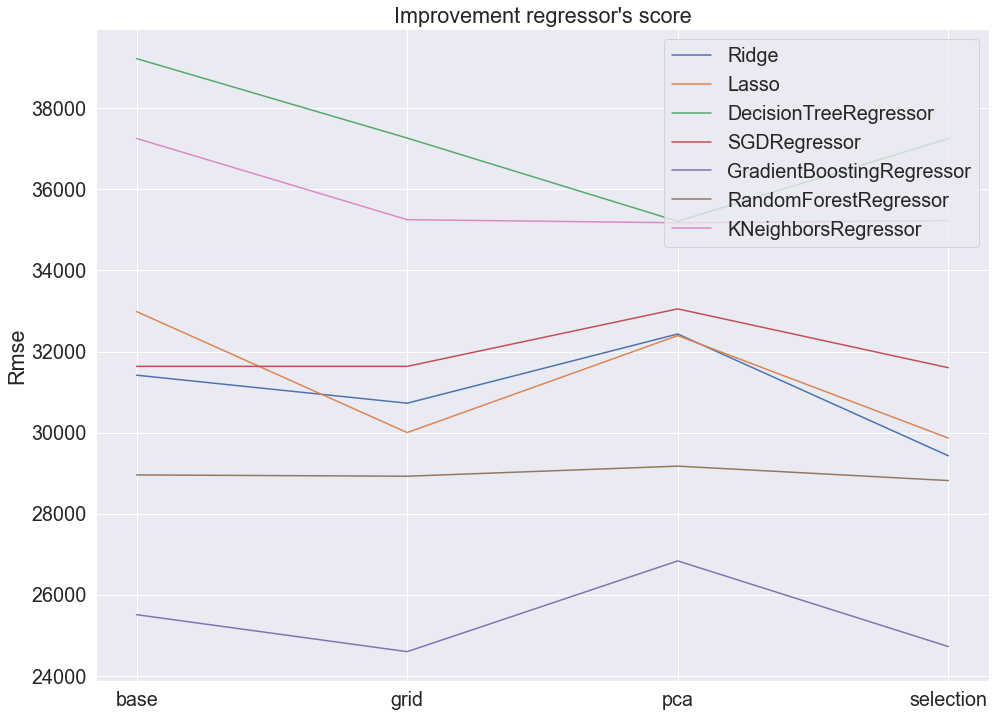

In [400]:
plt.figure(figsize=(16,12))
for i in range(res.shape[0]):
    res.loc[i,score_names].plot()
plt.legend(labels,loc=1)
plt.ylabel('Rmse')
plt.title("Improvement regressor's score")
plt.xticks(ticks = np.arange(4),labels=process);

PCA method of reducing dimensions worked bad. The main reason for this is that the data has a low correlation with SalePrice. Lasso selection sligthly improved quality of prediction. Because it removed not informative features(handle with multicollinearity).

### <center> 3.5 Final prediction </center>
After all steps was found that GradientBoostingRegressor is the most suitable for solution this problem. Remains to find out how much better GBR is than a LASSO.

In [417]:
X_train,X_test,y_train,y_test = train_test_split(X_selected,y,random_state=5)

In [423]:
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=5000,random_state=5,max_depth=3)
gbr.fit(X_train,y_train)
prediction = gbr.predict(X_test)
print('GradientBoostingRegressor MAPE:',np.int(np.sum(np.abs((y_test-prediction)/y_test*100))/prediction.shape[0])) 
print('GradientBoostingRegressor RMSE:',np.sqrt(mean_squared_error(y_test,prediction)))

GradientBoostingRegressor MAPE: 8
GradientBoostingRegressor RMSE: 23408.85941864371


Plot percentage error for all objects.  

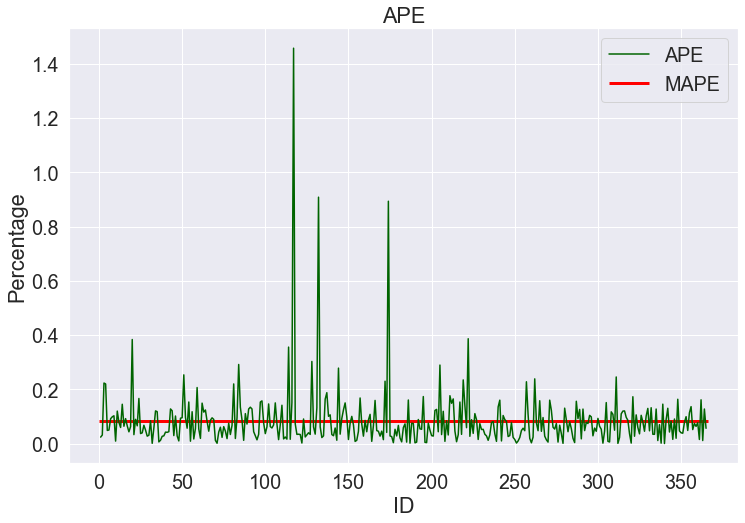

In [430]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(1,prediction.shape[0]+1),np.abs((y_test-prediction)/y_test),color='darkgreen',label='APE')
plt.title('APE')
plt.xlabel('ID')
plt.ylabel('Percentage')
plt.hlines(np.sum(np.abs((y_test-prediction)/y_test))/prediction.shape[0],xmin=0,xmax=prediction.shape[0]+1,colors='red',linewidth=3,label='MAPE')
plt.legend();

## <center> 4. Conclusion </center>

To sum up, house prices dataset contains a lot of different categoric and numeric columns which are varying much. Little preparation and basic lasso algorithm gave more than 10% MAPE and ~30000 RMSE that is not permissible. Changing model and further preprocessing improved quality (almost 8% MAPE with GradientBoostingRegressor). The dataset is very diverse and there are many different areas for improvement. Choosing more complex algorithms like xgboost or catboost and removing data from outliers will increase accuracy. 